In [3]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Add,Concatenate,Softmax
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
#import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math
from keras.activations import softmax,tanh
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6830725721675259124, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16045503284
 locality {
   bus_id: 1
 }
 incarnation: 11656644454999493927
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [5]:
with open('data-gender0.pckl','rb') as file:
    train_images,train_labels,test_images,test_labels = pickle.load(file)

In [6]:
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            #self.model.save_weights(filepath, overwrite=True)
                            print("asd")
                            try:
                                with open(filepath,'wb') as f:
                                    pickle.dump(self.model.get_weights(),f)
                            except Exception as ex:
                                print("Could not write",ex)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [24]:
def attention_block(x,K,labels,w,h):
    H = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    H = BatchNormalization()(H)
    spatial_softmax = Lambda(lambda x:softmax(H,axis=3))(H)
    O = Conv2D(labels*K, kernel_size=(w, h), padding="same")(x)
    O = BatchNormalization()(O)
    rH = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=3))(spatial_softmax)
    o = Lambda(lambda x: tf.einsum('bijk,bijk->bk',x[0],x[1]))([O,rH])
    tempH = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    tempH = BatchNormalization()(tempH)
    gh = Lambda(lambda x: softmax(tanh(tf.einsum('bijk,bijk->bk',x[0],x[1])),axis=1))([tempH,spatial_softmax])
    rgh = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=1))(gh)
    of = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([rgh,o])
    new_shape = Reshape((labels,K))(of)
    out = Lambda(lambda x: keras.backend.sum(x,axis=2))(new_shape)
    #x = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    #inter = Lambda(lambda x: Flatten()(keras.backend.mean(x,axis=3)))(x)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(x)
    inter = MaxPooling2D(pool_size=(4, 4))(inter)
    inter = BatchNormalization()(inter)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(inter)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    print(inter.shape)
    inter = Conv2D(1, kernel_size=(w, h), padding="same")(inter)
    inter = Flatten()(inter)
    weight = Dense(labels,activation='tanh')(inter)
    return out,weight

In [1]:
K = 10
labels = 1
w,h = 3,3

cnn_base = VGG16(input_shape=(448,448,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv1':
        break
    layer.trainable = False


x = cnn_base.get_layer('block3_conv3').output
final1,weight1 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])

x = cnn_base.get_layer('block4_conv3').output
final2,weight2 = attention_block(x,K,labels,w,h)

#final2 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final2,weight2])

x = cnn_base.get_layer('block5_pool').output
inter = Lambda(lambda x: Flatten()(x[:,:,:,0]))(x)
weight3 = Dense(1,activation='tanh')(inter)

x = Flatten()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1,activation='sigmoid')(x)

weight_concat = Concatenate()([weight1,weight2,weight3])
weight_concat = Softmax()(weight_concat)
final = Concatenate()([final1,final2,x])

final3 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([weight_concat,final])
final3 = Dense(1,activation='sigmoid')(final3)
model = Model(inputs=cnn_base.input, outputs=final3)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())
initial_weights = model.get_weights()

NameError: name 'VGG16' is not defined

In [29]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

In [31]:
for i in range(5):
    print("Loading file")
    with open('data-gender'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    try:
        with open('gender_classification_vgg16_attention'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    train_ls = []
    for l in train_labels:
        if l=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for l in test_labels:
        if l=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)

    class_weights = class_weight.compute_class_weight('balanced',np.unique(train_ls),train_ls)
    
    filepath="gender_classification_vgg16_attention-{val_acc:.2f}.hdf5"
    checkpoint = CustomModelCheckpoint('gender_classification_vgg16_attention'+str(i)+'.hd5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='max')
    callbacks_list = [checkpoint]

    #history = model.fit(x=np.array(train_images),y=np.array(train_ls),batch_size=5,epochs=50,
    #                  validation_data=(np.array(test_images),np.array(test_ls)),class_weight=class_weights,callbacks=callbacks_list)
    train_score = model.evaluate(x=np.array(train_images),y=np.array(train_ls),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_ls),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(train_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    
#     try:
#         with open('gender_classification_vgg16_attention'+str(i)+'.hd5','wb') as f:
#             pickle.dump(model.get_weights(),f)
#     except Exception as ex:
#         print("Could not write",ex)

Loading file
loaded model
38/38 [==============================] - 1s 23ms/step
predicting
Test Score [0.2355562001466751, 0.9210526347160339]
Loading file
loaded model
37/37 [==============================] - 1s 23ms/step
predicting
Test Score [0.38354769349098206, 0.9189189076423645]
Loading file
loaded model
37/37 [==============================] - 1s 23ms/step
predicting
Test Score [0.30336761474609375, 0.9459459185600281]
Loading file
loaded model
37/37 [==============================] - 1s 24ms/step
predicting
Test Score [0.2057931274175644, 0.9459459185600281]
Loading file
loaded model
36/36 [==============================] - 1s 24ms/step
predicting
Test Score [0.35455429553985596, 0.8888888955116272]


In [ ]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
if rotated:
    with open('vgg16-predictions-rotated.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)
else:
    with open('vgg16-predictions.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [ ]:
rotated

In [33]:
train_scores[5:10]

[[0.011432237940040035, 1.0],
 [0.012360869313229446, 1.0],
 [0.028729753178619855, 0.9977477498956628],
 [0.04165391721301251, 0.9954954997913258],
 [0.05883554279204183, 0.9932885970045257]]

In [34]:
test_scores[5:10]

[[0.2355562001466751, 0.9210526347160339],
 [0.38354769349098206, 0.9189189076423645],
 [0.30336761474609375, 0.9459459185600281],
 [0.2057931274175644, 0.9459459185600281],
 [0.35455429553985596, 0.8888888955116272]]

In [ ]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [6]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'classes.npy'

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101

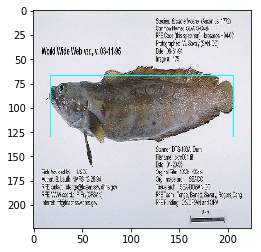

In [36]:
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

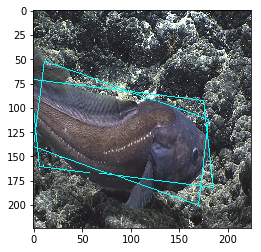

In [28]:
idx = 5
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [78]:
idx = 22
img = test_images[idx]
[[w,h,cx,cy,angle]] = mod.predict(np.expand_dims(test_images[idx],axis=0))[0]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [57]:
w,h,cx,cy,angle

(0.9990823, 0.00075547496, 4.3644923e-05, 0.00010419192, 1.4448374e-05)

In [53]:
mod.predict(np.expand_dims(test_images[6],axis=0))

[array([[149.92322 ,  82.941605, 126.17159 , 112.74586 ,  -0.889715]],
       dtype=float32),
 array([[1.1669288e-03, 9.3571018e-08, 7.4474216e-02, 3.6341050e-01,
         5.6094831e-01]], dtype=float32)]

In [79]:
test_scores

[]